<div dir='rtl'>

# پیاده سازی و آزمون روش Bus-Inverting
مهدی بهرامیان 401171593

برای پیاده سازی این روش از زبان cpp برای تسریع آزمایش استفاده میکنیم.

## جزئیات پیاده سازی
برای پیاده سازی موثر این روش ما ابتدا به روشی نیازمندیم که به طور موثر باس خود را نمایش دهیم.
برای این منظور کلاس runtime_bitset 
را تعریف میکنیم و برای آن توابع randomize و get و set را تعریف میکنیم.
</div>

```cpp
class runtime_bitset {
    std::vector<usize> m_data;

  public:
    usize sz;
    runtime_bitset(const usize sz) : sz(sz), m_data(sz / sizeof(usize) + 1) {}
    inline void randomize() {
        int i = 0;
        for (; i < sz / sizeof(usize); ++i) {
            m_data[i] = ud(gen);
        }
        if (i < m_data.size())
            m_data[i] = ud(gen) % (1 << (sz - i * sizeof(usize)));
    }
    inline bool get(usize i) const {
        if (i < sz)
            return (bool)(m_data[i / sizeof(usize)] &
                          (1 << (i % sizeof(usize))));
        return false;
    }
    inline void set(usize i, bool val) {
        if (i >= sz)
            return;
        usize xval = val << (i % sizeof(usize));
        usize bit = 1 << (i % sizeof(usize));
        usize cval = m_data[i / sizeof(usize)];
        cval = (cval & ~bit) | xval;
        m_data[i / sizeof(usize)] = cval;
    }
};
```
<div dir='rtl'>

سپس به توابعی نیازمندیم که 
در حالت عادی و در حالت bus-inverting 
میزان فعالیت باس را حساب کند.
همچنین برای تحلیل مونت کارلو به تابعی نیازمندیم که فعالیت میانگین دو حالت را 
حساب کند.

</div>

```cpp
usize normal_activity(const runtime_bitset &bs) {
    usize res = 0;
    for (usize i = 0; i < bs.sz; i += 1) {
        res += bs.get(i);
    }
    return res;
}
usize businv_activity(const runtime_bitset &bs, const usize split_size) {
    usize res = 0;
    for (usize i = 0; i < bs.sz; i += split_size) {
        usize cnt = 0;
        for (usize j = i; j < i + split_size && j < bs.sz; j++) {
            cnt += bs.get(j);
        }
        res += std::min(cnt, split_size + 1 - cnt);
    }
    return res;
}
std::pair<float, float> avg_activity(const usize numbits,
                                     const usize split_size) {
    runtime_bitset bs(numbits);
    float binv_activity = 0;
    float norm_activity = 0;
    for (int i = 0; i < ITER; i++) {
        bs.randomize();
        binv_activity += businv_activity(bs, split_size);
        norm_activity += normal_activity(bs);
    }
    return {norm_activity / ITER, binv_activity / ITER};
}
```

<div dir='rtl'>
در نهایت کافیست که صرفا به ازای حالات مختلف split از ۱ تا اندازه باس، 
میانگین فعالیت را محاسبه کنیم.
</div>

```cpp
int main(int argc, char **argv) {
    if (argc < 2) {
        usage(argv[0]);
        exit(1);
    }
    usize numbits;
    try {
        numbits = std::stoul(std::string(argv[1]));
    } catch (std::exception) {
        usage(argv[0]);
        exit(1);
    }

    std::cout << "Split\t" << "AvgNormActivity\t"
              << "AvgBinvActivity\t" << "Improvement" << std::endl;
    for (usize t = 1; t <= numbits; t++) {
        auto x = avg_activity(numbits, t);
        std::cout << t << '\t' << x.first << '\t' << x.second << '\t'
                  << 1 - (x.second / x.first) << std::endl;
    }
}
```

<div dir='rtl'>

## اجرای آزمون و ثبت نتایج
برای این منظور کافیست با استفاده از کد پایتون زیر، حالات مختلف این برنامه را اجرا نمود و نتایج را کشید.

</div>

make: Nothing to be done for 'all'.


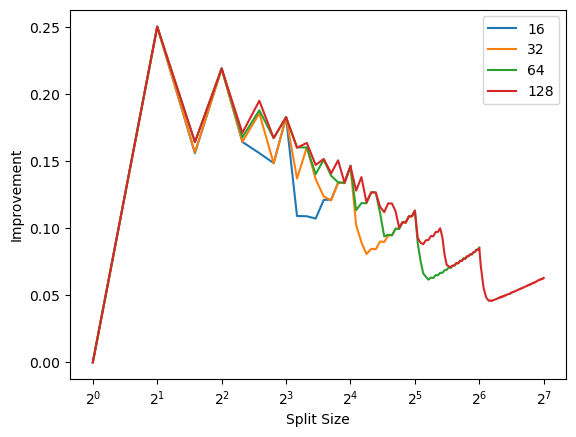

In [ ]:
from subprocess import run
from matplotlib import pyplot as plt
import polars
import csv
run(['make'])
for nbits in [16, 32, 64, 128] :
    res = run(['./businv', str(nbits)],capture_output = True, text=True).stdout
    res = csv.reader(res.splitlines(), delimiter='\t')
    next(res)
    x = []
    y = []
    for row in res:
        x.append(float(row[0]))
        y.append(float(row[3]))
    plt.plot(x,y, label=str(nbits))
plt.legend()
plt.ylabel('Improvement')
plt.xlabel('Split Size')
plt.xscale('log', base=2)
plt.show()
    

<div dir='rtl'>

## نتایج آزمون
همانطور که مشاهده میکنید، مستقل از طول باس،
split 
بهینه برابر با ۲ است و در این حالت تقریبا ۲۵ درصد بهبود داریم، البته این مورد سربار بسیار زیادی دارد.
</div>